# Команда Project 13
# Проект: Визуализатор объектов нейросетевых архитектур
Краткое описание: Разработка библиотеки на языке Python, которая позволяет визуализировать внутренние компоненты нейронных сетей, такие как эмбеддинги и матрицы внимания. Примеры данных: временные ряды, языковые модели.
Основные задачи:
1.     Реализация функционала для визуализации эмбеддингов и матриц внимания. Создать функции для визуализации векторных представлений данных, используя методы снижения размерности (например, t-SNE, UMAP).
2.     Интерпретация архитектур типа Transformer с помощью визуализатора – в таких моделях зависимости между данными с каждым слоем линеаризуются
3.     Внедрение поддержки дополнительных фичей в библиотеку, интерпретация нейросетевых архитектур для работы с многомерными временными рядами через эмбеддинги времени и координат с помощью визуализатора.
4. Визуализация процесса обучения с помощью цветовой карты величин градиентов и весов.
5. Визуализация важности весов в уже обученной модели.




На данный момент реализовано:
1. Визуализация графа нейронной сети
2. Визуализация весов слоя нейронной сети
3. Визуализация выхода слоя нейронной сети

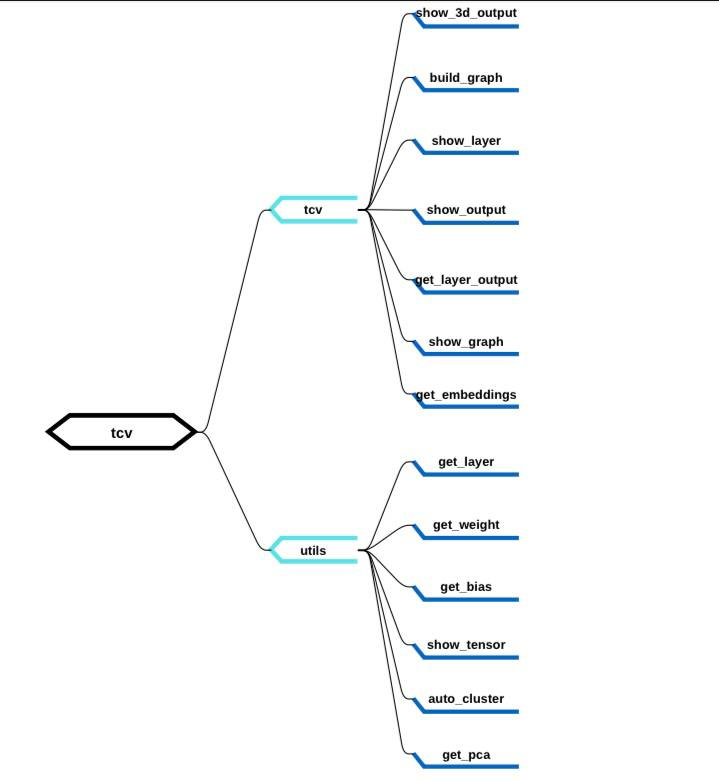

На картинке изображена структура нашей библиотеки

Для демонстрации работы мы взяли модель SAITS: imputation for time series

In [31]:
# import os

In [ ]:
# !pip install -r tcv/project13/saits/requirements.txt

In [1]:
from tcv.project13.saits.pypots.imputation import SAITS
import pandas as pd
import numpy as np
import torch

2025-02-06 19:56:52 [ERROR]: No module named 'torch_geometric'
torch_geometric is missing, please install it with 'pip install torch_geometric' or 'conda install -c pyg pyg'
2025-02-06 19:56:52 [ERROR]: name 'MessagePassing' is not defined
Note torch_geometric is missing, please install it with 'pip install torch_geometric' or 'conda install -c pyg pyg'


In [2]:
def form_train(array, seq_len, step):
    result_list = []
    for i in range(seq_len, len(array) + 1, step):
        result_list.append(np.expand_dims(array[i - seq_len : i], axis=0))
    return np.concatenate(result_list, axis=0)
data = pd.read_csv("tcv/project13/saits/data.csv")
seq_len = 40
train_values = form_train(data.drop("Date", axis=1).values, seq_len, 1)
assert np.allclose(
    train_values[1][0][~np.isnan(train_values[1][0])], 
    train_values[0][1][~np.isnan(train_values[0][1])]
)

train_data = {"X": train_values, "missing_mask": np.zeros_like(train_values)}
model_params = {
    "n_layers": 2,
    "d_model": 64,
    "d_inner": 32,
    "n_heads": 4,
    "d_k": 32,
    "d_v": 32,
    "dropout": 0.1,
    "epochs": 20,
    "n_steps": seq_len,
    "n_features": train_data["X"].shape[-1],
    "epochs": 20
}
input_data_t = {'X': torch.tensor(train_data['X'], dtype=torch.float32),
               'missing_mask': torch.tensor(train_data['missing_mask'], dtype=torch.float32)}
model = SAITS(**model_params)
# model.fit(train_data)
# model.save_model("weights", "pretrained_weights.pypots")
model.load_model("weights/pretrained_weights.pypots")

2025-02-06 19:56:52 [INFO]: No given device, using default device: cpu
2025-02-06 19:56:52 [WARNING]: saving_path not given. Model files and tensorboard file will not be saved.
2025-02-06 19:56:52 [INFO]: Model initialized successfully with the number of trainable parameters: 583,062
2025-02-06 19:56:53 [ERROR]: No module named 'torch_geometric'
torch_geometric is missing, please install it with 'pip install torch_geometric' or 'conda install -c pyg pyg'
2025-02-06 19:56:53 [ERROR]: No module named 'torch_geometric'
torch_geometric is missing, please install it with 'pip install torch_geometric' or 'conda install -c pyg pyg'
2025-02-06 19:56:53 [ERROR]: name 'MessagePassing' is not defined
Note torch_geometric is missing, please install it with 'pip install torch_geometric' or 'conda install -c pyg pyg'
2025-02-06 19:56:53 [ERROR]: name 'MessagePassing' is not defined
Note torch_geometric is missing, please install it with 'pip install torch_geometric' or 'conda install -c pyg pyg'
202

Получаем выход модели на каких то входных данных

In [3]:
out = model.model(input_data_t, True, False)

In [4]:
from tcv.project13.tcv import tcv

In [5]:
mapa, edges = tcv.build_graph(out['imputed_data'], params=dict(model.model.named_parameters()))

In [6]:
mapa_c, edges_c = tcv.distill_graph(mapa, edges)

In [7]:
tcv.show_graph(mapa_c, edges_c)

In [ ]:
names = {}
for i in mapa_c:
	names[i] = mapa_c[i].name
names.values()

In [ ]:
tcv.show_layer(model.model, 'layer_stack_for_second_block.1.slf_attn.w_qs')

In [11]:
import torch
import torch.nn as nn
import numpy as np


class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self._input = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
        )
        self._fc_mean  = nn.Linear(hidden_dim, latent_dim)
        self._fc_var   = nn.Linear (hidden_dim, latent_dim)

    def forward(self, x):
        output_  = self._input(x)
        mean_    = self._fc_mean(output_)
        log_var_ = self._fc_var(output_)
        return mean_, log_var_

enc = Encoder(1000, 1200, 4)
x = np.random.normal(1, size=1000)
t = torch.tensor(x, dtype=torch.float32).reshape(1, 1000)
out = enc(t)

In [ ]:
tcv.show_layer(enc, '_input.0')

In [ ]:
from transformers import BertModel
import matplotlib.pyplot as plt

model = BertModel.from_pretrained("bert-base-uncased", output_attentions=True)

In [ ]:
fig = tcv.show_output(model, input='Although the sun was shining brightly in the clear blue sky, and the birds were chirping melodiously in the tall trees that swayed gently in the warm summer breeze, Sarah, who had been waiting impatiently for her friends to arrive, sat on the wooden bench near the old fountain in the park, checking her phone repeatedly, while wondering whether they had forgotten about their plans or if they were simply running late, which, given their usual tendency to lose track of time, wouldn’t have surprised her in the slightest.')
fig.update_layout(width=1200, height=1200)  # Устанавливаем размер фигуры
fig.show()


In [ ]:
for layer in range(11):
	fig = tcv.show_output(model, layer=layer)
	fig.show()

In [ ]:
fig = tcv.show_3d_output(model, input='Although the sun was shining brightly in the clear blue sky, and the birds were chirping melodiously in the tall trees that swayed gently in the warm summer breeze, Sarah, who had been waiting impatiently for her friends to arrive, sat on the wooden bench near the old fountain in the park, checking her phone repeatedly, while wondering whether they had forgotten about their plans or if they were simply running late, which, given their usual tendency to lose track of time, wouldn’t have surprised her in the slightest.')
fig.update_layout(width=1200, height=1200)  # Устанавливаем размер фигуры
fig.show()

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        output = self.fc(last_hidden)
        return output, last_hidden

model = LSTMModel(input_dim=10, hidden_dim=64, output_dim=2)
input_len = 32
x = torch.rand(input_len, 20, 10)

fig = tcv.get_embeddings(model, 'fc', x)
fig.update_layout(width=600, height=600)  # Устанавливаем размер фигуры
fig.show()

In [ ]:
fig = tcv.get_embeddings(model, 'fc', x, ['1','2','3','4']*8)
fig.update_layout(width=600, height=600)  # Устанавливаем размер фигуры
fig.show()